<a href="https://colab.research.google.com/github/EricFan2002/SCUTmaterial/blob/master/Tutorial_on_DENT_DDSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DENT-DDSP: Data-Efficient Noisy Speech Generator using DDSP

This tutorial aims to introduce 2 new DDSP components in my recent published paper: [DENT-DDSP](https://arxiv.org/abs/2208.00987) at INTERSPEECH, namely *Waveshaping Distortion* and *Dynamic Range Compressor*. Also, this tutorial aims to help researchers who work in the field of noise-robust ASR to synthesize parallel datasets (clean speech and the speech transmitted from radio channels) without the need of manually recording those data. The demo webpage can be found [here](https://guozixunnicolas.github.io/DENT-DDSP-demo/). These newly proposed components have potentials to be utilzed in automatic music mixing tasks too. Kindly contact me for collaborations via my email from my  [website](https://guozixunnicolas.github.io/CV/).

##Install and Import Dependencies

In [ ]:
#@title
!pip install -qU ddsp
import warnings
warnings.filterwarnings("ignore")
import ddsp
from ddsp.colab.colab_utils import (play, record, specplot, upload)
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import yaml
sample_rate = 8000
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
!git clone https://github.com/guozixunnicolas/DENT_DDSP.git


     |████████████████████████████████| 212 kB 5.0 MB/s 
     |████████████████████████████████| 60.9 MB 1.2 MB/s 
     |████████████████████████████████| 210 kB 48.9 MB/s 
     |████████████████████████████████| 77 kB 3.0 MB/s 
     |████████████████████████████████| 90 kB 8.1 MB/s 
     |████████████████████████████████| 129 kB 51.3 MB/s 
     |████████████████████████████████| 1.1 MB 50.1 MB/s 
     |████████████████████████████████| 323 kB 50.7 MB/s 
     |████████████████████████████████| 5.6 MB 39.8 MB/s 
     |████████████████████████████████| 51 kB 5.5 MB/s 
     |████████████████████████████████| 40 kB 311 kB/s 
     |████████████████████████████████| 1.6 MB 47.3 MB/s 
     |████████████████████████████████| 216 kB 49.9 MB/s 
     |████████████████████████████████| 60.2 MB 1.3 MB/s 
     |████████████████████████████████| 42.5 MB 1.2 MB/s 
Cloning into 'DENT_DDSP'...
remote: Enumerating objects: 178, done.
remote: Counting objects: 100% (178/178), done.
remote: Compressing obj

## DENT-DDSP Overview and Demonstration
DENT-DDSP consists of multiple DDSP components connected as follows: ![picture](https://drive.google.com/uc?id=1tvLhxFr7Xiwd0fOQhgO_0eL-sH5yahnt)

Note that compared to the original DDSP paper, I made the parameters of the DDSP modules trainable which will be updated via training.


Let's first record some audio and use this as reference. You are recommended to read some texts or hum a melody. The reference audio will then pass through the DENT-DDSP chain to mimic to desired radio transmission effect ([RATS Dataset Channel A](https://aclanthology.org/L14-1089/)).

Starting recording for 5 seconds...


<IPython.core.display.Javascript object>

Finished recording!


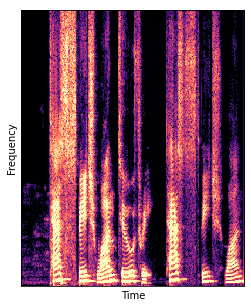

In [ ]:
#code courtesy to Google
#@markdown Record or Upload Audio

record_or_upload = "Record" #@param ["Record", "Upload (.mp3 or .wav)"]

record_seconds =   5#@param {type:"number", min:1, max:10, step:1}

if record_or_upload == "Record":
  audio = record(seconds=record_seconds)
else:
  # Load audio sample here (.mp3 or .wav3 file)
  # Just use the first file.
  filenames, audios = upload()
  audio = audios[0]

# Add batch dimension
audio = audio[np.newaxis, :]

# Listen.
specplot(audio)
play(audio)

###Passing the reference audio through the signal chain

original audio


noisy audio


original audio vs noisy audio (spectrogram)


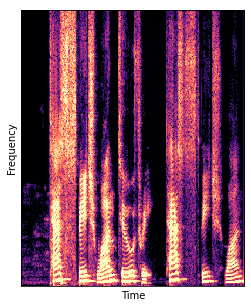

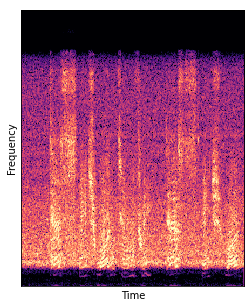

In [ ]:
from DENT_DDSP.model_freq_domain import signal_chain_gpu,SpectralLoss

#path and trained checkpoints
ckpt_path = "DENT_DDSP/checkpoints/03_07_2022_13_43_10_rats_small_train_thd0.8,1.0_sr8000_len10"
step = "ckpt-132"

#define model instance with initial model configuration
with open (ckpt_path+'/model.yaml', 'r') as f:
  cfg_model = yaml.safe_load(f)
model = signal_chain_gpu(EQ_cfg = cfg_model['FIRfilter'], DRC_cfg = cfg_model['compressor'], waveshaper_cfg=cfg_model['distortion'], noise_cfg = cfg_model['filtered_noise'])
ckpt = tf.train.Checkpoint(model=model)
#model with trained checkpoint
ckpt.restore(ckpt_path+"/"+step)

#building up the signal chain
@tf.function
def signal_chain_forward(inp_audio, noise_adjustment = None):
  output = model.waveshaper(inp_audio)
  output = model.DRC(output)
  output = model.EQ(output)
  noise = model.noise(output)
  if noise_adjustment is not None:
    adj_linear = 20**(noise_adjustment/20)
    noise*=adj_linear
  return output+noise

#passing the reference audio through the signal chain
noisy_audio = signal_chain_forward(audio)
print("original audio")
play(audio)
print("noisy audio")
play(noisy_audio)

print("original audio vs noisy audio (spectrogram)")
specplot(audio)
specplot(noisy_audio)






##Introducing 2 new DDSP modules: Waveshaping distortion and Dynamic Range Compressor

###Waveshaping distortion
The Waveshaping distortion or the waveshaper utilizes a arctan function to introduce non-linearity to the input audio. It's a commonly-used effect in the electric guitar community to distort guitar sounds. An extra gain-controlling variable is also introduced.

The code for the waveshaper exists in `model_freq_domain/core.py` but I will copy it here for illustration purposes.

Input sine wave


Note that when distortion gain is small, the audio doesn't sound distorted despite with a lower volume

Distorted sine wave with gain: 0.1


Distorted sine wave with gain: 5.0


Distorted sine wave with gain: 20.0


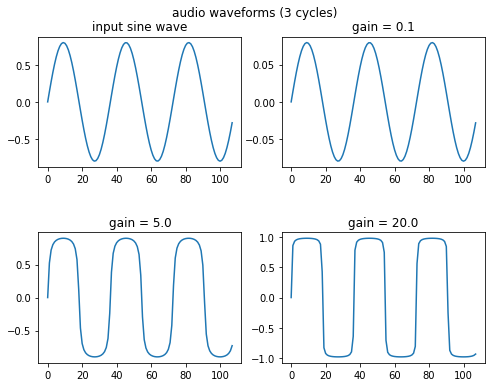

In [ ]:
import math
from DENT_DDSP.model_freq_domain.core import tf_float32

def waveshaper(audio, g_dist): #g_dist is a trainable parameter which represents the gain of distortion
	audio = tf_float32(audio)
	return (2/math.pi) * tf.math.atan( (0.5*math.pi*g_dist) * audio)

#creat several sine waves and pass them through the waveshaper
duration = 2
freq = 440
amplitude = 0.8
t = np.linspace(0., 1., duration*sample_rate)
sin_wave = amplitude*np.sin(2. * np.pi * freq * t)

#passing the sine wave through the waveshaper with different gain parameters
gain_list = [0.1, 5.0, 20.0] #different level of distortion
sin_wave_distorted_list = [(waveshaper(sin_wave, gain), gain) for gain in gain_list]
print("Input sine wave")
play(sin_wave)
print("Note that when distortion gain is small, the audio doesn't sound distorted despite with a lower volume\n")
for sin_wave_distorted, gain in sin_wave_distorted_list:
  print(f"Distorted sine wave with gain: {gain}")
  play(sin_wave_distorted)

#plotting the waveform of the input and distorted audio
num_cycles = 3
num_samples = 2*int(sample_rate/freq)*num_cycles
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
plt.subplots_adjust(hspace=0.5)
fig.suptitle(f"audio waveforms ({num_cycles} cycles)", fontsize=12, y=0.95)

axs.ravel()[0].plot(sin_wave[:num_samples])
axs.ravel()[0].set_title(f"input sine wave")

for distorted_audio_gain, ax in zip(sin_wave_distorted_list, axs.ravel()[1:]):
  distorted_audio, gain= distorted_audio_gain
  ax.plot(distorted_audio[:num_samples])
  ax.set_title(f"gain = {gain}")
  ax.set_xlabel("")
plt.show()
plt.close()



###Computationally-efficient Dynamic Range Compressor
The Dynamic Range Compressor (DRC), as the name suggests, compress the dynamic range of audio (in the audio domain). It's commonly used in music production in order to stablize the volume from various sound tracks. The audio transmitted by radio is heavily compressed by observation. Hence, I created a differentiable DRC as shown below.

It's controlled by several parameters: threshold (above which the audio will be compressed), ratio (amount of amplitude reduction), makeup (makeup gain after compressing), attack and release time (how fast the compressor "grabs" the transient).  These paramters are all made trainable (differentiable).

The code for the DRC exists in `model_freq_domain/core.py` but I will copy it here for illustration purposes.

In [ ]:
from DENT_DDSP.model_freq_domain.core import log10, resample, upsample_with_windows, compressor_smoothing_gain_cell_func

def compressor_time_averaged(audio,sr,threshold, ratio,makeup, attack_time,  release_time, downsample_factor = 16.0):

	#first convert into dB scale
	audio = tf_float32(audio)
	audio_db = 20*log10(abs(audio)+1e-8)

	#obtain gain reduction value
	compressed_audio_db = tf.where(tf.math.greater(audio_db, threshold),
								threshold+(audio_db-threshold)/ratio,audio_db)
	gain=tf.math.subtract(compressed_audio_db,audio_db) #[batch, length]

	#gain smoothing using the attack and release time
	#to reduce the computational complexity: first downsample the gain values, apply smoothing function, upsample the reduced gain values back
	gain_downsampled = resample(gain, int(gain.shape[1]/downsample_factor), method = 'linear')[..., tf.newaxis] #['nearest', 'linear', 'cubic', 'window']
	prev_sample = gain_downsampled[:, 0, :]
	smoothed_gain = tf.TensorArray(dtype=tf.float32, size=gain_downsampled.shape[1])
	def condition(i, out_seq, prev_sample):
		return tf.less(i, gain_downsampled.shape[1])
	def body(i, out_seq, prev_sample):
		prev_sample = compressor_smoothing_gain_cell_func(gain_downsampled[:,i,:],prev_sample, attack_time, release_time)
		out_seq = out_seq.write(i,prev_sample)
		return i+1, out_seq, prev_sample
	_, smoothed_gain, _ = tf.while_loop(condition, body, [0, smoothed_gain, prev_sample])
	gain_downsampled_smoothed = tf.transpose(smoothed_gain.stack(), perm = [1, 0, 2])

	gain_downsampled_smoothed_upsampled = upsample_with_windows(gain_downsampled_smoothed, int(gain_downsampled_smoothed.shape[1]*downsample_factor))

	#apply makeup gain
	smoothed_compressed_audio_db = audio_db + gain_downsampled_smoothed_upsampled[:, :gain.shape[1], 0] + makeup

	#convert to linear scale and apply signs
	smoothed_compressed_audio = 10.0**((smoothed_compressed_audio_db)/20.0)
	smoothed_compressed_audio = tf.where(audio<0, -smoothed_compressed_audio, smoothed_compressed_audio)
	return smoothed_compressed_audio


To better illustrate the compressing effect, we need to record another reference audio that has a larger dynamic range. You are recommended to clap you hands, or read some texts using different volumes (preferrablly from loud to quiet).

Starting recording for 5 seconds...


<IPython.core.display.Javascript object>

Finished recording!


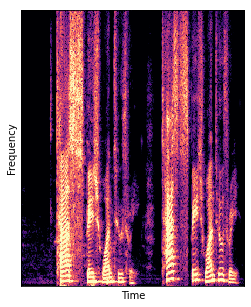

In [ ]:
#code courtesy to Google
#@markdown Record or Upload Audio

record_or_upload = "Record" #@param ["Record", "Upload (.mp3 or .wav)"]

record_seconds =   5#@param {type:"number", min:1, max:10, step:1}

if record_or_upload == "Record":
  audio2 = record(seconds=record_seconds)
else:
  # Load audio sample here (.mp3 or .wav3 file)
  # Just use the first file.
  filenames, audios = upload()
  audio2 = audios[0]

# Add batch dimension
audio2 = audio2[np.newaxis, :]

# Listen.
specplot(audio2)
play(audio2)

Now let's pass the audio through the compressor and check the effect.

original audio


compressed audio


Note that the compressed audio has a more even dynamic range (lower volume boosted while higher volume dampened).
Also, the audio sounds distorted since the compression level is high. This is desired if we want to create the radio transmission effect. But the compressor would work with music audio without distortion if parameters are adjusted accordingly.


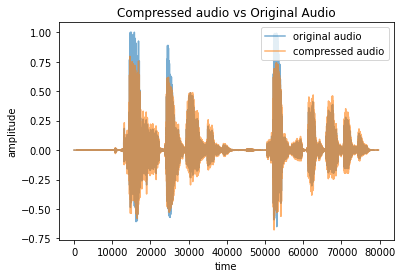

In [ ]:

threshold = -10
ratio = 10
makeup = 2
attack_time = 0.5
release_time = 0.5
compressed_audio = compressor_time_averaged(audio2,sample_rate,threshold, ratio,makeup, attack_time,  release_time, downsample_factor = 2.0)

#audio
print("original audio")
play(audio2)
print("compressed audio")
play(compressed_audio)

#waveform
plt.plot(np.array(audio2[0]), alpha = 0.6, label = "original audio")
plt.plot(np.array(compressed_audio[0]), alpha = 0.6, label = "compressed audio")
plt.title("Compressed audio vs Original Audio")
plt.xlabel("time")
plt.ylabel("amplitude")
plt.legend()
print("Note that the compressed audio has a more even dynamic range (lower volume boosted while higher volume dampened).")
print("Also, the audio sounds distorted since the compression level is high. This is desired if we want to create the radio transmission effect. But the compressor would work with music audio without distortion if parameters are adjusted accordingly.")


